## Описание проекта

Клиентам предлагают два тарифных плана: Смарт и Ультра. Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег. Предстояло сделать предварительный анализ тарифов на небольшой выборке клиентов. В  распоряжении данные 500 пользователей: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

[Шаг 1. Изучение общей информации](#step1)
- [Таблица calls](#calls)
- [Таблица internet](#internet)
- [Таблица users](#users)
- [Таблица tariffs](#tariffs)
- [Таблица messages](#messages)
- [Первичный вывод](#primary_conclusion)

[Шаг 2. Подготовка данных](#step2)
- [Приведение данных к нужным типам](#bringing_data)
- [Поиск и исправление ошибок в данных](#search_replace_errors)
   - [Добавление количества сделанных звонков и израсходованных минут разговора по месяцам.](#calls_monthly)
   - [Добавление количество отправленных сообщений по месяцам.](#messages_monthly)
   - [Добавление объема израсходованного интернет-трафика по месяцам.](#traffic_monthly)
   - [Добавление помесячной выручки.](#proceed_monthly)
        
[Шаг 3. Анализ данных](#step3)
- [Гистограммы отправленных сообщений по тарифам.](#hists_msgs)
- [Гистограммы минут разговоров.](#hists_minutes)
- [Гистограммы трафика по тарифам.](#hists_traffic)
- [Вывод](#conclusion_step3)
    
[Шаг 4. Проверка гипотез](#step4)
- [Гипотеза 1](#hyp1)
   - [Проверка равенства дисперсий выборок пользователей двух тарифных планов](#var_tariff)
   - [Проверка равенства выручек пользователей двух тарифных планов](#mean_tariff)
- [Гипотеза 2](#hyp2)
   - [Проверка равенства дисперсий выборок пользователей Москвы и регионов](#var_Msc_reg)
   - [Проверка равенства средних выборок пользователей Москвы и регионов](#mean_Msc_reg)

[Шаг 5. Общий вывод](#general_conclusion) 

## Шаг 1. Изучение общей информации. <a name="step1"></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import math

from scipy import stats as st
import matplotlib.pyplot as plt
from matplotlib import cm

### Таблица calls <a name="calls"></a>

In [2]:
calls_df = pd.read_csv('/datasets/calls.csv') 
calls_df.info()
calls_df['duration'] = np.ceil(calls_df['duration'])
display(calls_df.head())

print(calls_df.query('duration == 0')['duration'].count(), ' - количество звонков, длительность которых равна 0')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.0,1000
1,1000_1,2018-08-17,0.0,1000
2,1000_2,2018-06-11,3.0,1000
3,1000_3,2018-09-21,14.0,1000
4,1000_4,2018-12-15,6.0,1000


39613  - количество звонков, длительность которых равна 0


Таблица состоит из следующих столбцов:
* id — уникальный номер звонка;
* call_date — дата звонка;
* duration — длительность звонка в минутах;
* user_id — идентификатор пользователя, сделавшего звонок.

19.5% из всех звонков с нулевой длительностью, кажется весьма реалистичным, но обратим внимание в будущем на это явление.

### Таблица internet <a name="internet"></a>

In [3]:
internet_df = pd.read_csv('/datasets/internet.csv') 
internet_df.info()
internet_df['mb_used'] = np.ceil(internet_df['mb_used'])

display(internet_df.head())
print(len(internet_df['Unnamed: 0'].unique()))
internet_df.drop(['Unnamed: 0'], axis=1, inplace=True)
internet_df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,113.0,2018-11-25,1000
1,1,1000_1,1053.0,2018-09-07,1000
2,2,1000_2,1198.0,2018-06-25,1000
3,3,1000_3,551.0,2018-08-22,1000
4,4,1000_4,303.0,2018-09-24,1000


149396


Index(['id', 'mb_used', 'session_date', 'user_id'], dtype='object')

Таблица состоит из следующих столбцов:
* id — уникальный номер сессии;
* mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах);
* session_date — дата интернет-сессии;
* user_id — идентификатор пользователя.

Проверил, что все значения в столбце 'Unnamed: 0' уникальные (просто порядковые числа) в связи с чем удалил его за ненадобностью.

### Таблица users <a name="users"></a>

In [4]:
users_df = pd.read_csv('/datasets/users.csv') 
display(users_df.head())
users_df.info()
users_df['churn_date'].fillna('2020-07-14', inplace=True)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Таблица состоит из следующих столбцов:
* user_id — уникальный идентификатор пользователя;
* first_name — имя пользователя;
* last_name — фамилия пользователя;
* age — возраст пользователя (годы);
* reg_date — дата подключения тарифа (день, месяц, год);
* churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных);
* city — город проживания пользователя;
* tariff — название тарифного плана.

Тех людей, у которых дата прекращения пользования тарифом не указана азменил на значение, отличающиеся от представленных, но всё же дату, для потенциального удобства работы со столбцом.

### Таблица tariffs <a name="tariffs"></a>

In [5]:
tariffs_df = pd.read_csv('/datasets/tariffs.csv') 
tariffs_df.info()
display(tariffs_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Таблица состоит из следующих столбцов:
* tariff_name — название тарифа;
* rub_monthly_fee — ежемесячная абонентская плата в рублях;
* minutes_included — количество минут разговора в месяц, включённых в абонентскую плату;
* messages_included — количество сообщений в месяц, включённых в абонентскую плату;
* mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах);
* rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со * 101 минуты будет взиматься плата);
* rub_per_message — стоимость отправки сообщения сверх тарифного пакета;
* rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта).

Ничего неожиданного в данных обнаружено не было

### Таблица messages <a name="messages"></a>

In [6]:
messages_df = pd.read_csv('/datasets/messages.csv') 
messages_df.info()
display(messages_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


Таблица состоит из следующих столбцов:
* id — уникальный номер сообщения
* message_date — дата сообщения
* user_id — идентификатор пользователя, отправившего сообщение

На первый взгляд чего-либо неожиданного найдено не было, кроме того, что и во всех предыдущих столбцах с данными формат дат не распознается. Изменим это на следующем шаге.

### Первичный вывод <a name="primary_conclusion"></a>

* calls - выбросов нет, звонки с длительностью 0 - пропущенные, их 19% считаю допустимым;
* internet - удалил столбец 'Unnamed: 0' по причине его неинформативности;
* users - столбец 'churn_date' имел пропуски, это неудивительно, ведь не все разрывают контракты, в связи с чем такие пропуски заменил на выделяющееся значение;
* tariffs - аномалий нет;
* messages - ошибок нет.

## Шаг 2. Подготовка данных <a name="step2"></a>

### Приведение данных к нужным типам <a name="bringing_data"></a>

In [7]:
calls_df['call_date'] = pd.to_datetime(calls_df['call_date'])
print(calls_df.dtypes)

internet_df['session_date'] = pd.to_datetime(internet_df['session_date'])
print(internet_df.dtypes)

users_df['reg_date'] = pd.to_datetime(users_df['reg_date'])
users_df['churn_date'] = pd.to_datetime(users_df['churn_date'])
print(users_df.dtypes)

messages_df['message_date'] = pd.to_datetime(messages_df['message_date'])
messages_df.dtypes

id                   object
call_date    datetime64[ns]
duration            float64
user_id               int64
dtype: object
id                      object
mb_used                float64
session_date    datetime64[ns]
user_id                  int64
dtype: object
user_id                int64
age                    int64
churn_date    datetime64[ns]
city                  object
first_name            object
last_name             object
reg_date      datetime64[ns]
tariff                object
dtype: object


id                      object
message_date    datetime64[ns]
user_id                  int64
dtype: object

### Поиск и исправление ошибок в данных <a name="search_replace_errors"></a>

#### Добавление количества сделанных звонков и израсходованных минут разговора по месяцам. <a name="calls_monthly"></a>

In [8]:
calls_df['year_and_month'] = pd.to_datetime(calls_df['call_date']).dt.to_period('M')
user_id_count_calls_df = pd.DataFrame(calls_df.groupby(['user_id', 'year_and_month'])[['duration']].
                                      agg(['count', 'sum']))

user_id_count_calls_df.reset_index(inplace=True)
user_id_count_calls_df.columns = ['user_id', 'year_and_month', 'count_calls', 'total_duration_calls']

if 'count_calls' not in users_df.columns:
    users_df = users_df.merge(user_id_count_calls_df, how='left',on=['user_id'])

users_df.info()
users_df['year_and_month'].fillna(pd.Period('2020-07'), inplace=True)
users_df.fillna(0, inplace=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3182 entries, 0 to 3181
Data columns (total 11 columns):
user_id                 3182 non-null int64
age                     3182 non-null int64
churn_date              3182 non-null datetime64[ns]
city                    3182 non-null object
first_name              3182 non-null object
last_name               3182 non-null object
reg_date                3182 non-null datetime64[ns]
tariff                  3182 non-null object
year_and_month          3174 non-null period[M]
count_calls             3174 non-null float64
total_duration_calls    3174 non-null float64
dtypes: datetime64[ns](2), float64(2), int64(2), object(4), period[M](1)
memory usage: 298.3+ KB


В восьми вставляемых значениях есть пропуски, у этого может быть две причины:
* Пользователь просто не разговаривает по телефону;
* О некоторых клиентах неизвестно их взаимодействие со звонками.

Предположив, что пропуски связаны с тем, что человек не пользуется звонками обнулил пропущенные значения в столбцах с параметрами звонка, а дата указана производная выбивающаяся из набора данных.

#### Добавление количество отправленных сообщений по месяцам. <a name="messages_monthly"></a>

In [9]:
messages_df['year_and_month'] = pd.to_datetime(messages_df['message_date']).dt.to_period('M')
messages_aggregate_df = pd.DataFrame(messages_df.groupby(['user_id', 'year_and_month'])[['user_id']].
                                     agg(['count']).reset_index())
messages_aggregate_df.columns = ['user_id', 'year_and_month', 'count_msg']

if 'count_msg' not in users_df.columns:
    users_df = users_df.merge(messages_aggregate_df, how='left',on=['user_id', 'year_and_month'])

users_df.info()
print(users_df.groupby('user_id')[['count_msg']].sum().info())
users_df.fillna(0,inplace=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3182 entries, 0 to 3181
Data columns (total 12 columns):
user_id                 3182 non-null int64
age                     3182 non-null int64
churn_date              3182 non-null datetime64[ns]
city                    3182 non-null object
first_name              3182 non-null object
last_name               3182 non-null object
reg_date                3182 non-null datetime64[ns]
tariff                  3182 non-null object
year_and_month          3182 non-null period[M]
count_calls             3182 non-null float64
total_duration_calls    3182 non-null float64
count_msg               2678 non-null float64
dtypes: datetime64[ns](2), float64(3), int64(2), object(4), period[M](1)
memory usage: 323.2+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 1000 to 1499
Data columns (total 1 columns):
count_msg    500 non-null float64
dtypes: float64(1)
memory usage: 7.8 KB
None


Есть месяца в которые отдельные люди не пользовались отправкой сообщений, также проверил, что хоть одно сообщение задетектировано для каждого пользователя, в связи с чем пропущенные просто заменил на 0.

#### Добавление объема израсходованного интернет-трафика по месяцам. <a name="traffic_monthly"></a>

In [10]:
internet_df['year_and_month'] = pd.to_datetime(internet_df['session_date']).dt.to_period('M')
internet_aggregate_df = pd.DataFrame(internet_df.groupby(['user_id', 'year_and_month'])[['mb_used']].
                                     agg(['sum']).reset_index())
internet_aggregate_df.columns = ['user_id', 'year_and_month', 'sum_mb_used']

if 'sum_mb_used' not in users_df.columns:
    users_df = users_df.merge(internet_aggregate_df, how='left',on=['user_id', 'year_and_month'])

users_df.info()
print(users_df.groupby('user_id')[['sum_mb_used']].sum().info())
users_df.fillna(0,inplace=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3182 entries, 0 to 3181
Data columns (total 13 columns):
user_id                 3182 non-null int64
age                     3182 non-null int64
churn_date              3182 non-null datetime64[ns]
city                    3182 non-null object
first_name              3182 non-null object
last_name               3182 non-null object
reg_date                3182 non-null datetime64[ns]
tariff                  3182 non-null object
year_and_month          3182 non-null period[M]
count_calls             3182 non-null float64
total_duration_calls    3182 non-null float64
count_msg               3182 non-null float64
sum_mb_used             3163 non-null float64
dtypes: datetime64[ns](2), float64(4), int64(2), object(4), period[M](1)
memory usage: 348.0+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 1000 to 1499
Data columns (total 1 columns):
sum_mb_used    500 non-null float64
dtypes: float64(1)
memory usage: 7.8 KB
None


Есть месяца, в которые отдельные люди не пользовались интернетом сообщений, также проверил, что расход траффика задетектирован для каждого пользователя, в связи с чем пропущенные просто заменил на 0.

#### Добавление помесячной выручки. <a name="proceed_monthly"></a>

In [11]:
users_df['count_calls'] = users_df['count_calls'].astype(int)
users_df['count_msg'] = users_df['count_msg'].astype(int)

def generate_proceed(row):
    tariff_name = row['tariff']
    tariff = tariffs_df.query('tariff_name == @tariff_name')
    
    spent_minutes_over_tariff = math.ceil(row['total_duration_calls'] - tariff['minutes_included'])
    spent_messages_over_tariff = int(row['count_msg'] - tariff['messages_included'])
    spent_net_over_tariff = math.ceil((row['sum_mb_used'] - tariff['mb_per_month_included']) / 1024)
    total_proceed = int(tariff['rub_monthly_fee'])

    if spent_minutes_over_tariff > 0:
        total_proceed += spent_minutes_over_tariff * tariff['rub_per_minute']
    if spent_messages_over_tariff > 0:
        total_proceed += spent_messages_over_tariff * tariff['rub_per_message']
    if spent_net_over_tariff > 0:
        total_proceed += spent_net_over_tariff * tariff['rub_per_gb']
            
    return int(total_proceed) 
    
users_df['total_proceed'] = users_df.apply(generate_proceed, axis=1)

users_df.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,year_and_month,count_calls,total_duration_calls,count_msg,sum_mb_used,total_proceed
0,1000,52,2020-07-14,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-05,22,159.0,22,2256.0,1950
1,1000,52,2020-07-14,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-06,43,172.0,60,23257.0,1950
2,1000,52,2020-07-14,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-07,47,340.0,75,14016.0,1950
3,1000,52,2020-07-14,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-08,52,408.0,81,14070.0,1950
4,1000,52,2020-07-14,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-09,58,466.0,57,14581.0,1950


Выделил потраченные минуты, сообщения, траффик сверх тарифного плана умножил на стоимость по тарифному плану и прибавил стоимость абонентской платы, тем самым получив выручку с каждого отдельного пользователя в конкретный месяц.

## Шаг 3. Анализ данных <a name="step3"></a>

In [12]:
if 'sum_gb_used' not in users_df.columns:
    users_df['total_duration_calls'] = users_df['total_duration_calls'] / 60 
    users_df['sum_mb_used'] = users_df['sum_mb_used'] / 1024
    users_df = users_df.rename(columns={"sum_mb_used": "sum_gb_used"})

display(round(users_df.pivot_table(index='tariff', values='count_msg', aggfunc=['count', 'mean', 'var', 'std']), 2))
display(round(users_df.pivot_table(index='tariff', values='total_duration_calls', aggfunc=['count', 'mean', 'var', 'std']), 2))
display(round(users_df.pivot_table(index='tariff', values='sum_gb_used', aggfunc=['count', 'mean', 'var', 'std']), 2))

,count,mean,var,std
,count_msg,count_msg,count_msg,count_msg
tariff,,,,
smart,2225,33.37,798.88,28.26
ultra,957,48.73,2199.93,46.90


,count,mean,var,std
,total_duration_calls,total_duration_calls,total_duration_calls,total_duration_calls
tariff,,,,
smart,2225,6.98,9.99,3.16
ultra,957,9.03,26.52,5.15


,count,mean,var,std
,sum_gb_used,sum_gb_used,sum_gb_used,sum_gb_used
tariff,,,,
smart,2225,15.84,33.21,5.76
ultra,957,18.90,99.62,9.98


Доступнее, когда объем траффика представлен в гигабайтах, а время переговоров в часах, поэтому изменил единицы измерения.

### Гистограммы отправленных сообщений по тарифам. <a name="hists_msgs"></a>

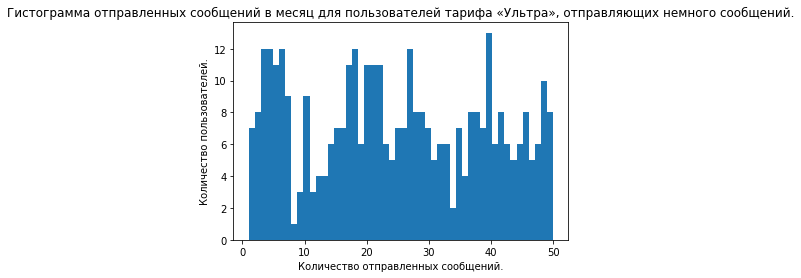

In [13]:
users_df.query('tariff == "ultra"')['count_msg'].plot(kind='hist', bins=50, range=(1,50))
plt.title("Гистограмма отправленных сообщений в месяц для пользователей тарифа «Ультра», отправляющих немного сообщений.")
plt.xlabel("Количество отправленных сообщений.")
plt.ylabel("Количество пользователей.");

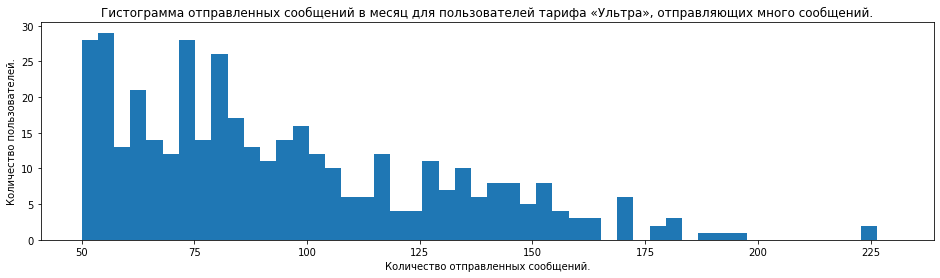

In [14]:
users_df.query('tariff == "ultra"')['count_msg'].plot(kind='hist', bins=50, range=(50,230), figsize=(16,4))
plt.title("Гистограмма отправленных сообщений в месяц для пользователей тарифа «Ультра», отправляющих много сообщений.")
plt.xlabel("Количество отправленных сообщений.")
plt.ylabel("Количество пользователей.");

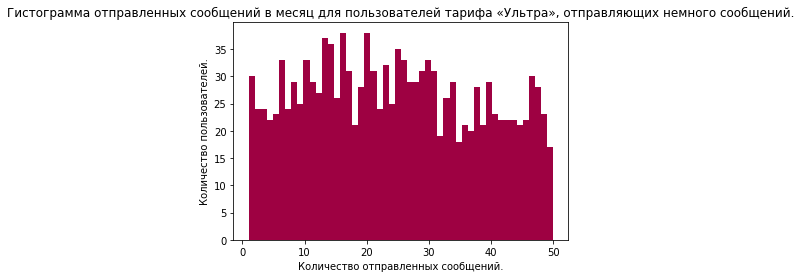

In [15]:
cmap = cm.get_cmap('Spectral') 

users_df.query('tariff == "smart"')['count_msg'].plot(kind='hist', bins=50, range=(1,50), cmap = cmap)
plt.title("Гистограмма отправленных сообщений в месяц для пользователей тарифа «Ультра», отправляющих немного сообщений.")
plt.xlabel("Количество отправленных сообщений.")
plt.ylabel("Количество пользователей.");

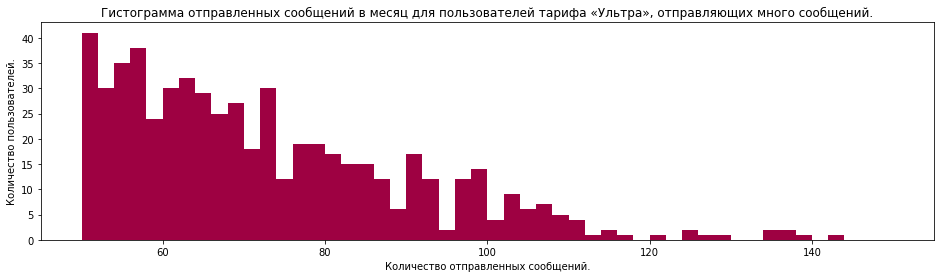

In [16]:
users_df.query('tariff == "smart"')['count_msg'].plot(kind='hist', bins=50, range=(50,150), cmap = cmap, figsize=(16,4))
plt.title("Гистограмма отправленных сообщений в месяц для пользователей тарифа «Ультра», отправляющих много сообщений.")
plt.xlabel("Количество отправленных сообщений.")
plt.ylabel("Количество пользователей.");

In [17]:
display(round(users_df.pivot_table(index='tariff', values='count_msg', aggfunc=['describe']), 2))

describe                                              
            25%   50%   75%   count    max   mean  min    std
tariff                                                       
smart      10.0  28.0  51.0  2225.0  143.0  33.37  0.0  28.26
ultra       5.0  39.0  79.0   957.0  224.0  48.73  0.0  46.90

Пользователи тарифа «Ультра» примерно в полтора раза чаще отправляют сообщения, чем люди пользующиеся тарифом «Смарт», эта взаимосвязь прослеживается при сравнении второй, третьей квартили, максимальных значений 

### Гистограммы минут разговоров. <a name="hists_minutes"></a>

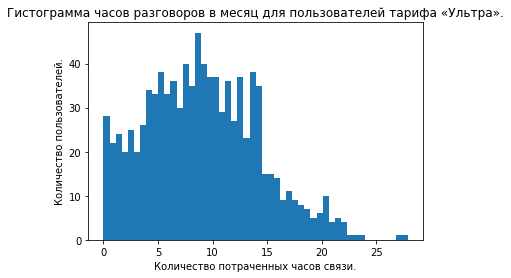

In [18]:
users_df.query('tariff == "ultra"')['total_duration_calls'].plot(kind='hist', bins=50)
plt.title("Гистограмма часов разговоров в месяц для пользователей тарифа «Ультра».")
plt.xlabel("Количество потраченных часов связи.")
plt.ylabel("Количество пользователей.");

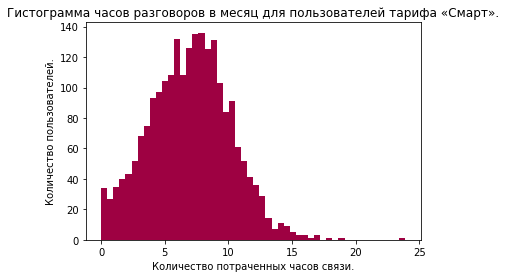

In [19]:
users_df.query('tariff == "smart"')['total_duration_calls'].plot(kind='hist', bins=50, cmap=cmap)
plt.title("Гистограмма часов разговоров в месяц для пользователей тарифа «Смарт».")
plt.xlabel("Количество потраченных часов связи.")
plt.ylabel("Количество пользователей.");

In [20]:
display(round(users_df.pivot_table(index='tariff', values='total_duration_calls', aggfunc=['describe']), 2))

describe                                             
            25%   50%    75%   count    max  mean  min   std
tariff                                                      
smart      4.73  7.03   9.08  2225.0  23.92  6.98  0.0  3.16
ultra      5.13  8.75  12.60   957.0  27.88  9.03  0.0  5.15

Распределение людей по часам разговора несимметрично, уномодально, при этом пользователи тарифа «Смарт» разговаривают реже, чем абоненты тарифного плана «Ультра».

### Гистограммы трафика по тарифам. <a name="hists_traffic"></a>

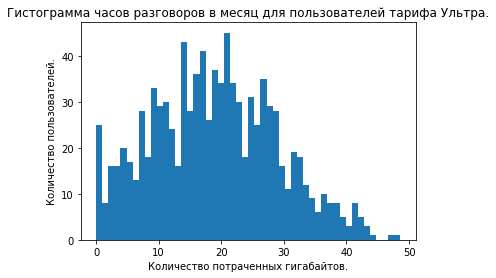

In [21]:
users_df.query('tariff == "ultra"')['sum_gb_used'].plot(kind='hist', bins=50)
plt.title("Гистограмма часов разговоров в месяц для пользователей тарифа Ультра.")
plt.xlabel("Количество потраченных гигабайтов.")
plt.ylabel("Количество пользователей.");

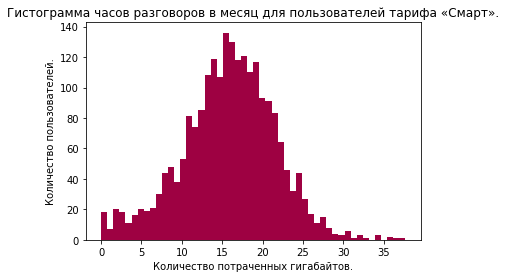

In [22]:
users_df.query('tariff == "smart"')['sum_gb_used'].plot(kind='hist', bins=50, cmap=cmap)
plt.title("Гистограмма часов разговоров в месяц для пользователей тарифа «Смарт».")
plt.xlabel("Количество потраченных гигабайтов.")
plt.ylabel("Количество пользователей.");

In [23]:
display(round(users_df.pivot_table(index='tariff', values='sum_gb_used', aggfunc=['describe']), 2))

describe                                               
            25%    50%    75%   count    max   mean  min   std
tariff                                                        
smart     12.34  16.11  19.60  2225.0  37.71  15.84  0.0  5.76
ultra     11.15  18.86  26.19   957.0  48.62  18.90  0.0  9.98

Распределение людей, пользующихся тарифом «Смарт» схоже с нормальным, как и при рассмотрении трат предыдущих опций пользователи тарифа «Ультра» более активно пользуются интернетом.

### Вывод <a name="conclusion_step3"></a>

Пользователи тарифа «Ультра» тратят более коммуникабельны в целом, при этом разница в потреблении различных способах коммуникаций неоднородна, сообщений отправляют примерно в полтора раза больше, а остальными опциями пользуются не настолько активнее.
75 процентам пользователей достаточно следующего количества минут, сообщений, траффика:
* Ультра 
    * 26.16	Гигабайт;
    * 79 сообщений;
    * 11.91 часа.
* Смарт
    * 19.58 Гигабайт;
    * 51 сообщений;
    * 8.59 часов.

## Шаг 4. Проверка гипотез <a name="step4"></a>

### Гипотеза 1 <a name="hyp1"></a>

Нулевая гипотеза - средние выручки пользователей тарифов «Ультра» и «Смарт» равны между собой.
Альтернативная - средние выручки  пользователей тарифов «Ультра» и «Смарт» не равны между собой.

#### Проверка равенства дисперсий выборок пользователей двух тарифных планов <a name="var_tariff"></a>

In [24]:
alpha = .05

users_df_tariff_ultra = users_df.query('tariff == "ultra"')['total_proceed']
users_df_tariff_smart = users_df.query('tariff == "smart"')['total_proceed']

stat, p = st.levene(users_df_tariff_ultra, users_df_tariff_smart)
print('p-значение:', p)

if (p < alpha):
    print("Отвергаем гипотезу о равенстве дисперсий")
else:
    print("Принимаем гипотезу о равенстве дисперсий") 

p-значение: 1.0923340364431958e-121
Отвергаем гипотезу о равенстве дисперсий


Воспользовавшись тестом Левена для проверки равенства дисперсий в группах можем осознанно использовать Т-критерий Стьюдента с опцией показывающей неравенство дисперсий. 

#### Проверка равенства выручек пользователей двух тарифных планов  <a name="mean_tariff"></a>

In [25]:
results_hypothesis_equality_tests = st.ttest_ind(
    users_df_tariff_ultra, 
    users_df_tariff_smart, equal_var = False)

print('p-значение:', results_hypothesis_equality_tests.pvalue)

if (results_hypothesis_equality_tests.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 1.6749696862727309e-242
Отвергаем нулевую гипотезу


Чтобы проверить гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам, применил метод scipy.stats.ttest_ind, предназначенный для проверки гипотез о равенстве средних.

### Гипотеза 2 <a name="hyp2"></a>

Нулевая гипотеза - средние выручки пользователей Москвы и иных регионов равны между собой.
Альтернативная - средние выручки  пользователей Москвы и иных регионов не равны между собой.

#### Проверка равенства дисперсий выборок пользователей Москвы и регионов <a name="var_Msc_reg"></a>

In [26]:
alpha = .05

users_df_Moscow = users_df.query('city == "Москва"')['total_proceed']
users_df_other_regions = users_df.query('city != "Москва"')['total_proceed']

stat, p = st.levene(users_df_Moscow, users_df_other_regions)
print('p-значение:', p)

if (p < alpha):
    print("Отвергаем гипотезу о равенстве дисперсий")
else:
    print("Принимаем гипотезу о равенстве дисперсий") 

p-значение: 0.007579313972060715
Отвергаем гипотезу о равенстве дисперсий


Воспользовавшись тестом Левена для проверки равенства дисперсий в группах можем осознанно использовать Т-критерий Стьюдента с опцией показывающей неравенство дисперсий. 

#### Проверка равенства средних выборок пользователей Москвы и регионов mean_Msc_reg<a name="mean_Msc_reg"></a>

In [27]:
results_hypothesis_equality_tests = st.ttest_ind(
    users_df_Moscow, 
    users_df_other_regions, equal_var = False)

print('p-значение:', results_hypothesis_equality_tests.pvalue)

if (results_hypothesis_equality_tests.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.4339860402809208
Не получилось отвергнуть нулевую гипотезу


Чтобы проверить гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам, применил метод scipy.stats.ttest_ind, предназначенный для проверки гипотез о равенстве средних.

## Шаг 5. Общий вывод <a name="general_conclusion"></a>

В процессе предварительного анализа тарифов клиентов на небольшой выборке из 500 человек было выявлено следующее:
При рассмотрении полученных таблиц обнаружено:
* calls - выбросов нет, звонки с длительностью 0 - пропущенные, их 19% считаю допустимым;
* internet - удалил столбец 'Unnamed: 0' по причине его неинформативности;
* users - столбец 'churn_date' имел пропуски, это неудивительно, ведь не все разрывают контракты, в связи с чем такие пропуски заменил на выделяющееся значение;
* Столбцы, содержащие значения дат не были в формате дат.

Были добавлены следующие столбцы:
* Количество сделанных звонков и израсходованных минут разговора по месяцам;
* Количество отправленных сообщений по месяцам;
* Объем израсходованного интернет-трафика по месяцам;
* Помесячная выручка с каждого пользователя.

Было выяснено, что 75 процентам пользователей достаточно следующего количества опций:
* Ультра 
    * 26.16	Гигабайт;
    * 79 сообщений;
    * 11.91 часа.
* Смарт
    * 19.58 Гигабайт;
    * 51 сообщений;
    * 8.59 часов.
    
Выявлено, что пользователи тарифного плана «Ультра» больше пользуются услугами.

Была опровергнута гипотеза, что пользователи тарифа «Ультра» и «Смарт» приносят в среднем равную выручку компании
Была подтверждена гипотеза, что пользователи Москвы и иных регионов приносят в среднем равную выручку компании

При доказательстве этих фактов доказывалась нулевая гипотеза равенства средних значений, доказательство которой проще. 

На основании проведенного анализа выявлено, что в среднем тариф «Ультра» выгоднее для компании, что пользование людьми средствами коммуникации от месяца к месяцу может меняться, что все люди из выборки за время наблюдения хотя бы в одном месяце пользовались каждым средством связи.